# Robotic Systems I (ECE-DK808)

## Electrical and Computer Engineering Department, University of Patras, Greece

**Instructor:** Konstantinos Chatzilygeroudis (costashatz@upatras.gr)

## Lab 6

### Differential Drive Robot

We want to write an EKF SLAM for a `Differential Drive Robot`:

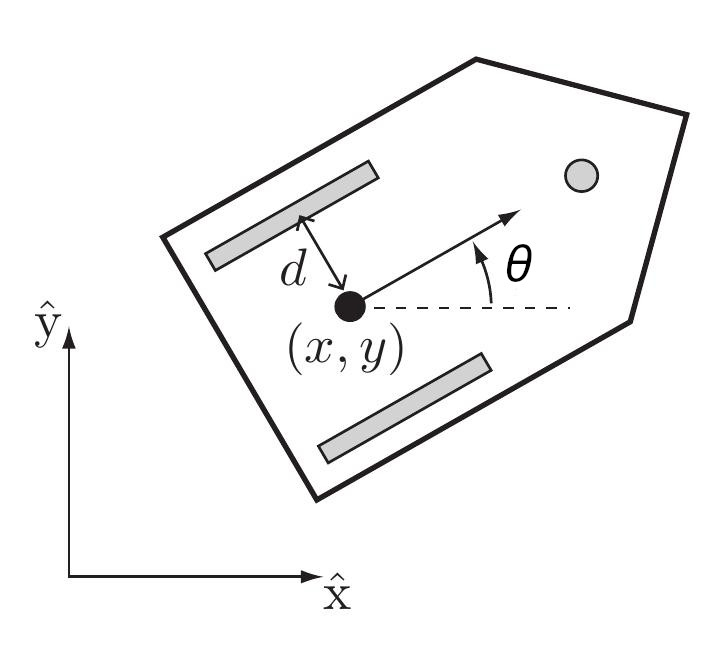

The state of a differential drive robot is $\boldsymbol{x} = [\theta, x, y]^T$. And the kinematic equations are given by:

$\begin{bmatrix}\dot{\theta}\\\dot{x}\\\dot{y}\end{bmatrix} = \begin{bmatrix}-\frac{r}{2d} & \frac{r}{2d}\\\frac{r}{2}\cos\theta & \frac{r}{2}\cos\theta\\\frac{r}{2}\sin\theta & \frac{r}{2}\sin\theta\end{bmatrix}\begin{bmatrix}u_L\\u_R\end{bmatrix}$

where $(\theta, x, y)$ is the pose of the robot in world space, $r$ are the wheel radii, $d$ is the distance of the wheels from the robot center, $\theta_L, \theta_R$ are the wheel rotation angles (values from encoder of the motors) and $u_L,u_R$ are the wheel angular velocities (commands).


In [16]:
import numpy as np # Linear Algebra
import matplotlib.pyplot as plt # Plotting
from matplotlib.patches import Rectangle, Circle # for visualizing the robot, landmarks

In [17]:
# Our first job is to write the kinematics
# distance of wheels
wheel_distance = 0.25
# radii
wheel_radius = 0.1

def diff_drive_kinematics(x, u):
    ### TO-DO: Write the differential drive kinematics. $\dot{x} = f(x, u), x = [θ, x, y]^T, u = [u_l, u_R]^T$
    ### ANSWER: Insert code here
    x = x.reshape((3))
    u = u.reshape((2))
    
    A = np.array([[-wheel_radius/(2*wheel_distance), wheel_radius/(2*wheel_distance)],
                  [   (wheel_radius/2)*np.cos(x[0]),   (wheel_radius/2)*np.cos(x[0])],
                  [   (wheel_radius/2)*np.sin(x[0]),   (wheel_radius/2)*np.sin(x[0])]])
    B = np.array([[u[0]],
                  [u[1]]])
    
    x_dot = A @ B

    return x_dot
    ### END of ANSWER

In [18]:
x = np.random.randn(3, 1)
u = np.zeros((2, 1))

assert(np.isclose(diff_drive_kinematics(x, u), np.zeros((3, 1))).all())

x1 = np.random.randn(3, 1)
x2 = np.random.randn(3, 1)
x1[0, 0] = x2[0, 0]
u = np.random.randn(2, 1)

assert(np.isclose(diff_drive_kinematics(x1, u), diff_drive_kinematics(x2, u)).all())

x = np.random.randn(3, 1)
u = np.ones((2, 1))

dx = diff_drive_kinematics(x, u)
assert(np.isclose(dx[0, 0], 0.))
assert(np.isclose(dx[1, 0], wheel_radius * np.cos(x[0, 0])))


In [19]:
# A helper function
def angle_dist(b, a):
    theta = b - a
    while theta < -np.pi:
        theta += 2. * np.pi
    while theta > np.pi:
        theta -= 2. * np.pi
    return theta

### Map

We now need to define a map! Let's create 8 landmarks! We also need a function called `lidar()` that can gives us sensor readings (2D Range Bearing)!

Given a landmark at position $[m_x, m_y]^T$ and the robot's state $[\theta, x, y]^T$, the function should return $[r, \phi]^T$ as the measurement:

$r = \sqrt{(m_x - x)^2 + (m_y - y)^2}$

$\phi = \text{atan2}(m_y - y, m_x - x) - \theta$

We return the measurements only for the landmarks with $-\frac{w}{2}\leq\phi\leq\frac{w}{2}$, where $w$ is the range/width of the sensor.

**Note:** `atan2(y, x)` is an efficient and robust implementation of $\text{atan}(\frac{y}{x})$, and always outputs an angle in $[-\pi,\pi]$.

In [20]:
# Map
# We have several landmarks!
landmarks = [(4., 4.), (4., 0.), (4., -4.), (0., -4.), (-4., -4.), (-4., 0.), (-4., 4.), (0., 4.)]
colors = ['red', 'blue', 'green', 'yellow', 'magenta', 'black', 'purple', 'orange']

# We assume that the robot is equiped with a lidar
#   the lidar has a width centered in the heading of the robot
#   the lidar can also have some noise

# To create the lidar function we will first create the building block
def robot_landmark_2d_measurement(robot_state, landmark_state):
    # robot_state: x = [θ, x, y]^T (numpy 3x1 array)
    # landmark_state = (m_x, m_y) (tuple)
    ### TO-DO: Compute the 2D measurement for the robot_state and the landmark_state
    ### You should return a tuple with (distance, relative_angle)
    ### ANSWER: Insert code here
    robot_state = robot_state.reshape((robot_state.shape[0]))
    mx = landmark_state[0]
    my = landmark_state[1]
    
    distance = np.sqrt((mx - robot_state[1])**2 + (my - robot_state[2])**2) # r
    relative_angle = angle_dist(np.arctan2(my - robot_state[2], mx - robot_state[1]), robot_state[0]) # phi
    
    return (distance, relative_angle)
    ### END of ANSWER

# Let's create a function that given the pose of the robot, return the hits of the lidar rays
def lidar(x, landmarks, width = 2. * np.pi, noise = 1e-3):
    detects = []

    ### TO-DO: Compute all possible detects. You should fill the list detects with tuples of the form (distance, relative_angle, landmark id)
    ### The landmark ids should be 1-based.
    ### You should add Gaussian noise to the distance and relative angle with zero mean and `noise` as variance
    for k in range(len(landmarks)):
        ### ANSWER: Insert code here
        robot_state = x
        landmark_state = landmarks[k]
        landmark_id = k+1

        s1 = np.random.randn()
        s2 = np.random.randn()
        mean = 0.   # μ
        cov = noise # σ**2
        e1 = mean + s1 * cov
        e2 = mean + s2 * cov
        
        measurement = robot_landmark_2d_measurement(robot_state, landmark_state)
        r = measurement[0] + e1
        phi = measurement[1] + e2
        l = (r, phi, landmark_id)
        
        if((phi >= -width/2) and (phi <= width/2)):
            detects.append(l)
        ### END of ANSWER
    return detects

In [21]:
x = np.array([[0., 0., 0.]]).T
l = (1., 1.)

dist, rel = robot_landmark_2d_measurement(x, l)
assert(np.isclose(dist, np.sqrt(2), rtol=1e-3))
assert(np.isclose(rel, 45. * np.pi / 180., rtol=1e-3))

x[0, 0] = 45. * np.pi / 180.
dist, rel = robot_landmark_2d_measurement(x, l)
assert(np.isclose(dist, np.sqrt(2), rtol=1e-3))
assert(np.isclose(rel, 0., rtol=1e-3))

x[0, 0] = -45. * np.pi / 180.
dist, rel = robot_landmark_2d_measurement(x, l)
assert(np.isclose(dist, np.sqrt(2), rtol=1e-3))
assert(np.isclose(rel, np.pi / 2., rtol=1e-3))

x[0, 0] = 225. * np.pi / 180.
dist, rel = robot_landmark_2d_measurement(x, l)
assert(np.isclose(dist, np.sqrt(2), rtol=1e-3))
assert(np.isclose(rel, -np.pi, rtol=1e-3))

x[0, 0] = -225. * np.pi / 180.
dist, rel = robot_landmark_2d_measurement(x, l)
assert(np.isclose(dist, np.sqrt(2), rtol=1e-3))
assert(np.isclose(rel, -np.pi / 2., rtol=1e-3))


In [22]:
np.random.seed(10) # for reproducability

x = np.array([[0., 0.01, 0.01]]).T

detects = lidar(x, landmarks, 0., 0.)

assert(len(detects) == 0)

detects = lidar(x, landmarks, np.pi / 4., 0.)
assert(len(detects) == 1)
assert(np.isclose(detects[0][0], 3.99, rtol=1e-2))
assert(np.isclose(detects[0][1] * 1000., -2.5, rtol=1e-2))
assert(detects[0][2] == 2)

new_detects = lidar(x, landmarks, np.pi / 4., 0.1)
assert(len(detects) == len(new_detects))
assert(not np.isclose(detects[0][0], new_detects[0][0], rtol=1e-2))
assert(not np.isclose(detects[0][1], new_detects[0][1], rtol=1e-2))

x[0, 0] = np.pi
detects = lidar(x, landmarks, np.pi / 4., 0.)
assert(len(detects) == 1)
assert(np.isclose(detects[0][0], 4.01, rtol=1e-2))
assert(np.isclose(detects[0][1] * 1000., 2.5, rtol=1e-2))
assert(detects[0][2] == 6)

new_detects = lidar(x, landmarks, np.pi / 4., 0.1)
assert(len(detects) == len(new_detects))
assert(not np.isclose(detects[0][0], new_detects[0][0], rtol=1e-3))
assert(not np.isclose(detects[0][1], new_detects[0][1], rtol=1e-2))

### Motion Model and Odometry

Now we need to implement a motion model for EKF! Let's create the simplest possible:

$\begin{bmatrix}\theta'\\x'\\y'\end{bmatrix} = \begin{bmatrix}\theta\\x\\y\end{bmatrix} + \begin{bmatrix}\delta\theta\\\delta x\\\delta y\end{bmatrix}$

We also need a function to transform odometry to "actions" for this model.

Finally, we need to write an integration function for computing the odometry.

In [23]:
# Motion model and derivative
def motion_model(x, u, dt = 0.1):
    out = np.copy(x)
    out[:3, :] += u # only the robot state is affected
    return out

def motion_model_deriv(x, u, dt = 0.1):
    return np.eye(x.shape[0])

# Helper function: get action u from actual odometry poses
def u_from_poses(xn, xp, dt = 0.1):
    dx = xn[1, 0] - xp[1, 0]
    dy = xn[2, 0] - xp[2, 0]
    dtheta = angle_dist(xn[0, 0], xp[0, 0])
    return np.array([[dtheta, dx, dy]]).T

# Odometry integration
def integrate(p, Vb, dt):
    # p: previous/current odometry estimate: p = [θ, x, y]^T
    # Vb: commanded velocity (given the differential drive kinematics) in body frame
    # dt: timestep to perform Euler integration
    ### TO-DO: Compute and return the next odometry pose
    ### ANSWER: Insert code here
    theta = p[0][0] # θp
    Uxb = Vb[1][0]  # Ux body
    Uyb = Vb[2][0]  # Uy body
    
    Uxy_b = np.array([[Uxb],
                     [Uyb]])    
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta),  np.cos(theta)]])
    Uxy_w = R @ Uxy_b
    
    Vw = np.block([[Vb[0][0]], [Uxy_w]])
    p_new = p + Vw * dt
    
    return p_new
    ### END of ANSWER

In [24]:
np.random.seed(25)

x = np.random.randn(3, 1)
u = np.random.randn(2, 1)
Vb = diff_drive_kinematics(np.array([[0., x[1, 0], x[2, 0]]]).T, u)
xn = integrate(x, Vb, 0.1)

assert(np.isclose(xn, np.array([[0.22095895, 1.01929344, -0.84105929]]).T, rtol=1e-3).all())
xn = integrate(x, Vb, 0.)
assert(np.isclose(xn, x, rtol=1e-3).all())


### Observation Model

Now we need to choose an observation model! We'll use the model that we saw for the 2D Range-Bearing sensors! We need to create a function that accepts as input the robot state and the landmark position, and gives us back $(r,\phi)$ where $r$ is the distance from the robot to the landmark and $\phi$ is the relative angle. We *also need the gradients!*

This is very similar to the `lidar()` function (except that we do not check if the landmark is in the visible region). You can use the `robot_landmark_2d_measurement` function.

In [25]:
# Observation model and derivative
def observation_model(x, landmark_pose):
    # x: robot pose (a 3x1 numpy array)
    # landmark_pose (a 2x1 numpy array)
    ### TO-DO: Compute the observation model! Return a 2x1 numpy array with [[distance], [relative angle]]
    ### ANSWER: Insert code here
    observation = robot_landmark_2d_measurement(x, landmark_pose)
    observation = np.array([[observation[0][0]], [observation[1][0]]])
    
    return observation
    ### END of ANSWER

def observation_model_deriv(x, landmark_pose):
    ### TO-DO: Compute the derivative of the above wrt the robot pose (x), and landmark pose
    ### Store the result in the `jac` variable
    jac = np.zeros((2, 5))
    ### ANSWER: Insert code here
    mx = landmark_pose[0][0]
    my = landmark_pose[1][0]
    
    o = observation_model(x, landmark_pose)
    r = o[0][0]
    jac = np.array([[ 0,     -(mx - x[1][0])/r,     -(my - x[2][0])/r,      (mx - x[1][0])/r,      (my - x[2][0])/r],
                    [-1, (my - x[2][0])/(r**2), (x[1][0] - mx)/(r**2), (x[2][0] - my)/(r**2), (mx - x[1][0])/(r**2)]])
    ### END of ANSWER

    return jac

In [26]:
def finite_diff(f, z, M, eps = 1e-4):
    N = z.shape[0]
    jac = np.zeros((M, N))
    v = np.zeros((N, 1))
    for i in range(N):
        zp = np.copy(z)
        v[i] = eps
        zp = zp + v
        zm = np.copy(z)
        v[i] = -eps
        zm = zm + v
        jac[:, i:i+1] = (((f(zp) - f(zm))) / (2. * eps)).reshape((-1, 1))
    return jac

x = np.array([[0., 0., 0.]]).T
l = (1., 1.)

dist, rel = robot_landmark_2d_measurement(x, l)
res = np.array([[dist], [rel]])
assert(np.isclose(res, observation_model(x, np.array([[l[0]], [l[1]]])), rtol=1e-3).all())

for _ in range(20):
    x = np.random.randn(3, 1)
    l = np.random.randn(2, 1)
    assert(np.isclose(observation_model_deriv(x, l), finite_diff(lambda p : observation_model(p[:3, :], p[3:, :]), np.vstack([x, l]), 2), rtol=1e-2).all())

### EKF SLAM

Now we can start writing the EKF SLAM step!

1. Compute $\overline{\boldsymbol{\mu}}_t$ only for the robot states given the motion model
2. Compute $\overline{\boldsymbol{\Sigma}}_t$ as
   $\overline{\boldsymbol{\Sigma}}_t = \begin{bmatrix}\boldsymbol{F}_t\boldsymbol{\Sigma}_{\boldsymbol{x}_R\boldsymbol{x}_R}\boldsymbol{F}_t^T + \boldsymbol{R}_t & \boldsymbol{F}_t\boldsymbol{\Sigma}_{\boldsymbol{x}_R\boldsymbol{m}}\\\boldsymbol{\Sigma}_{\boldsymbol{m}\boldsymbol{x}_R}\boldsymbol{F}_t^T&\boldsymbol{\Sigma}_{\boldsymbol{m}\boldsymbol{m}}\end{bmatrix}$
3. For each visible landmark, compute *expected* observation: $h(\overline{\boldsymbol{\mu}}_t)$
4. Compute $\boldsymbol{H}_t$ and proceed with the rest of EKF!

where $\boldsymbol{F}_t = \frac{\partial f}{\partial\boldsymbol{x}}\Big|_{\substack{\scriptsize\begin{aligned}\boldsymbol{x}&=\boldsymbol{\mu}_{t-1}\\\boldsymbol{u}&=\boldsymbol{u}_t\end{aligned}}}$, $\boldsymbol{H}_t=\frac{\partial h}{\partial\boldsymbol{x}}\Big|_{\boldsymbol{x}=\overline{\boldsymbol{\mu}}_t}$, $f(\cdot,\cdot)$ is the motion model and $h(\cdot)$ is the observation model.

In [27]:
# Let's create first the motion update (aka, the prediction step)
def ekf_slam_prediction_step(mu, sig, u, R):
    ### TO-DO: Write the motion update/prediction step of EKF SLAM. Store the results in variables named `mu_bar` and `sig_bar`
    ### ANSWER: Insert code here
    F = motion_model_deriv(mu, u)[:3,:3]
    mu_bar = motion_model(mu, u)
    sig_bar = np.block([[(F @ (sig[:3,:3]) @ F.T) + R, F @ (sig[:3,3:])],
                        [          (sig[3:,:3]) @ F.T,        sig[3:,3:]]
                       ])
    ### END of ANSWER
    return mu_bar, sig_bar

# Now let's write the initialization of a new landmark (aka, what happens when we first see one of the landmarks)
def ekf_slam_new_landmark(mu_bar, sig_bar, distance, relative_angle, index_in_matrix, Q):
    # mu_bar: current mean estimate
    # sig_bar: current variance estimate
    # distance: measured distance from robot to landmark
    # relative_angle: relative measured angle from robot to landmark
    # index_in_matrix: index of current landmark
    # Q: observation noise
    ### TO-DO: Compute the new mean and variance filling the values for the measured landmark. Store the results in variables named `mu_updated` and `sig_updated`
    mu_updated = np.copy(mu_bar)
    sig_updated = np.copy(sig_bar)
    ### ANSWER: Insert code here
    theta_r = mu_bar[0, 0]
    xr = mu_bar[1, 0]
    yr = mu_bar[2, 0]
    
    theta = theta_r + relative_angle
    xl = xr + distance * np.cos(theta)
    yl = yr + distance * np.sin(theta)

    mu_updated[index_in_matrix, 0] = xl
    mu_updated[index_in_matrix + 1, 0] = yl

    sig_updated[index_in_matrix:index_in_matrix + 2, index_in_matrix: index_in_matrix + 2] = Q
    ### END of ANSWER
    return mu_updated, sig_updated

# Finally, let's write the equations for the Kalman correction step. This function should operate in per-landmark case
def ekf_slam_correction_step(mu_bar, sig_bar, z, landmark_index, Q):
    # mu_bar: current mean estimate
    # sig_bar: current variance estimate
    # z: measured observation (numpy array of 2x1)
    # landmark_index: index of landmark
    # Q: observation noise
    ### TO-DO: Compute the new mean and variance. Store the results in variables named `mu_updated` and `sig_updated`
    mu_updated = np.copy(mu_bar)
    sig_updated = np.copy(sig_bar)
    ### ANSWER: Insert code here
    x = mu_bar[:3, :]
    landmark_pose = mu_bar[landmark_index:landmark_index + 2, :]
    h = observation_model(x, landmark_pose)
    H = observation_model_deriv(x, landmark_pose)[:, 3:]
    
    sig_bar = sig_bar[landmark_index:landmark_index + 2, landmark_index:landmark_index + 2]
    K = sig_bar @ H.T @ np.linalg.inv(H @ sig_bar @ H.T + Q)
    
    mu_updated[landmark_index:landmark_index + 2, :] = mu_bar[landmark_index:landmark_index + 2, :] + K @ (z - h)
    sig_updated = (np.eye(2) - K @ H) @ sig_bar
    ### END of ANSWER
    return mu_updated, sig_updated

In [28]:
x = np.random.randn(3 + 2 * len(landmarks), 1)
S = np.eye(3 + 2 * len(landmarks))
u = np.zeros((3, 1))
R = np.eye(3) * 0.

xn, Sn = ekf_slam_prediction_step(x, S, u, R)
assert(np.isclose(xn, x).all())
assert(np.isclose(Sn, S).all())

u = np.ones((3, 1))
xn, Sn = ekf_slam_prediction_step(x, S, u, R)
assert(np.isclose(xn[3:], x[3:]).all())
assert(np.isclose(xn[:3], x[:3] + u).all())
assert(np.isclose(Sn, S).all())

In [29]:
x = np.zeros((3 + 2 * len(landmarks), 1))
S = np.eye(3 + 2 * len(landmarks))
Q = np.eye(2) * 2.

distance = 2.
relative_angle = 1.
landmark_index = 1
index_in_matrix = 3 + 2 * landmark_index

xn, Sn = ekf_slam_new_landmark(x, S, distance, relative_angle, index_in_matrix, Q)
assert(np.isclose(Sn[index_in_matrix : index_in_matrix + 2, index_in_matrix : index_in_matrix + 2], Q).all())
assert(np.isclose(xn[index_in_matrix, 0], 2. * np.cos(1.), rtol=1e-3).all())
assert(np.isclose(xn[index_in_matrix + 1, 0], 2. * np.sin(1.), rtol=1e-3).all())

x[0, 0] = 1.
xn, Sn = ekf_slam_new_landmark(x, S, distance, relative_angle, index_in_matrix, Q)
assert(np.isclose(Sn[index_in_matrix : index_in_matrix + 2, index_in_matrix : index_in_matrix + 2], Q).all())
assert(np.isclose(xn[index_in_matrix, 0], 2. * np.cos(2.), rtol=1e-3).all())
assert(np.isclose(xn[index_in_matrix + 1, 0], 2. * np.sin(2.), rtol=1e-3).all())

In [30]:
x = np.zeros((3 + 2 * len(landmarks), 1))
x[1, 0] = x[2, 0] = -2.
S = np.eye(3 + 2 * len(landmarks))
Q = np.eye(2) * 0.

landmark_index = 1
index_in_matrix = 3 + 2 * landmark_index
x[index_in_matrix, 0] = landmarks[landmark_index][0]
x[index_in_matrix + 1, 0] = landmarks[landmark_index][1]
z = observation_model(x[:3, :], x[index_in_matrix : index_in_matrix + 2, :])

xn, Sn = ekf_slam_correction_step(x, S, z, landmark_index, Q)
assert(np.isclose(xn, x).all())
assert(not np.isclose(Sn[index_in_matrix : index_in_matrix + 2, index_in_matrix : index_in_matrix + 2], S[index_in_matrix : index_in_matrix + 2, index_in_matrix : index_in_matrix + 2]).all())
assert(not np.isclose(Sn[:3, :3], S[:3, :3]).all())

Q = np.eye(2) * 0.1
z[0, 0] += 0.1
z[1, 0] -= 0.2
xn, Sn = ekf_slam_correction_step(x, S, z, landmark_index, Q)
xp = np.array([[0.174, -2.054, -1.989, 0., 0., 4.054, -0.011, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]).T
assert(np.isclose(xn, xp, rtol=1e-2).all())
Sp = np.array([[0.569, -0.136], [-0.136, 0.933]])
assert(np.isclose(Sn[index_in_matrix : index_in_matrix + 2, index_in_matrix : index_in_matrix + 2], Sp, rtol=1e-2).all())
Sp = np.array([[0.13, 0.043, -0.13], [0.043, 0.569, -0.136], [-0.13, -0.136, 0.933]])
assert(np.isclose(Sn[:3, :3], Sp, atol=1e-3).all())

/tmp/ipykernel_2989102/1252165812.py:23: RuntimeWarning: invalid value encountered in scalar divide
  jac = np.array([[ 0,     -(mx - x[1][0])/r,     -(my - x[2][0])/r,      (mx - x[1][0])/r,      (my - x[2][0])/r],
/tmp/ipykernel_2989102/1252165812.py:24: RuntimeWarning: invalid value encountered in scalar divide
  [-1, (my - x[2][0])/(r**2), (x[1][0] - mx)/(r**2), (x[2][0] - my)/(r**2), (mx - x[1][0])/(r**2)]])


AssertionError: 

In [31]:
UNSEEN = 1000000.

# EKF SLAM Update
def ekf_slam_step(mu, sig, u, z, R, Q):
    mu_bar, sig_bar = ekf_slam_prediction_step(mu, sig, u, R)
    for k in range(len(z)):
        r_i = z[k][0]
        phi_i = z[k][1]
        landmark_index = (z[k][2] - 1)
        index_in_matrix = 3 + landmark_index * 2
        if sig_bar[index_in_matrix, index_in_matrix] == UNSEEN: # first time we see this landmark!
            mu_bar, sig_bar = ekf_slam_new_landmark(mu_bar, sig_bar, r_i, phi_i, index_in_matrix, Q)
        zk = np.array([[r_i, phi_i]]).T
        mu_bar, sig_bar = ekf_slam_correction_step(mu_bar, sig_bar, zk, landmark_index, Q)
    return mu_bar, sig_bar

### Running an experiment

We can now run the experiment! We first need to define our motion and sensor noises! Then, we need to compute nice initializations!

In [32]:
# Print iterations progress
def printProgressBar(iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()

In [33]:
R = np.eye(3) * 0.01 # noise for movement!
Q = np.eye(2) * 0.001 # noise for observation!

# Initial state and variance
p = np.zeros((3, 1)) # position and theta of the base (θ, x, y)
p[1, 0] = -2.
p[2, 0] = 2.

# EKF initialization
x = np.zeros((3 + 2 * len(landmarks), 1)) # We have 3 + 2 * len(landmarks) variables! (3 for the robot and 2 for each landmark!)
x[:3, :] = np.copy(p)
S_init = np.eye(3 + 2 * len(landmarks)) * 0.001 # We start with a small uncertainty!
S_init[3:, 3:] = np.eye(2 * len(landmarks)) * UNSEEN # One way of checking for non-initialized landmarks!

# Let's create a target list
# target poses
targets = []
# We do not care about the orientation!
targets += [np.array([[0., 2., -2.]]).T]
targets += [np.array([[0., -3., -3.]]).T]
targets += [np.array([[0., 3., 3.]]).T]
curr_target = 0

# timestep
dt = 0.1

# error threshold
angle_thres = 0.01

# For odometry
odom_poses = [np.copy(p)]
odom_p = np.copy(p)
H_odom = np.array([[-wheel_radius/(2.*wheel_distance), wheel_radius/(2.*wheel_distance)], [wheel_radius/2., wheel_radius/2.], [0., 0.]])

all_poses = [np.copy(p)]
estimation = [(np.copy(x), S_init)]
max_steps = 20000
step = 0

pos_diff = targets[curr_target][1:, :] - p[1:, :]
while curr_target < len(targets) and np.linalg.norm(pos_diff) > 1e-2: # while we haven't reached the target
    printProgressBar(step, max_steps - 1)
    pos_diff = targets[curr_target][1:, :] - p[1:, :]

    dist = np.linalg.norm(pos_diff)
    steer_direction = np.arctan2(pos_diff[1, 0], pos_diff[0, 0]) - p[0, 0]
    u = np.array([[0., 0.]]).T
    motor_value = 0.5
    if dist > 1e-3:
        if steer_direction > angle_thres:
            v = min(steer_direction, motor_value)
            u[0, 0] = -v
            u[1, 0] = v
        elif steer_direction < -angle_thres:
            v = min(-steer_direction, motor_value)
            u[0, 0] = v
            u[1, 0] = -v
        else:
            u[0, 0] = u[1, 0] = min(1., 0.5 * dist)

    # Forward simulation using the kinematics + Euler integration
    u_bad = np.copy(u)
    u_bad[1, 0] = 0.99 * u[1, 0] # one wheel is spinning more!
    v = diff_drive_kinematics(p, u_bad)
    p = p + v * dt

    # Compute Odometry!
    Vb = H_odom @ u
    odom_p = integrate(odom_p, Vb, dt)
    # Just for visuals
    all_poses += [np.copy(p)]
    odom_poses += [np.copy(odom_p)]
    # EKF SLAM update
    mu, sig = estimation[-1]
    u_slam = u_from_poses(odom_poses[-1], odom_poses[-2], dt) # compute odometry controls

    z = lidar(p, landmarks, noise=1e-3)
    estimation.append(ekf_slam_step(mu, sig, u_slam, z, R, Q))

    step += 1
    if step >= max_steps:
        break
    pos_diff = targets[curr_target][1:, :] - p[1:, :]

    if np.linalg.norm(pos_diff) <= 1e-2:
        curr_target += 1
        curr_target = curr_target % len(targets)
        pos_diff = np.ones((2,1))

np.set_printoptions(precision = 3, suppress = True, linewidth = 200)
print(estimation[-1][0][:3, :].T)
# print(estimation[-1][1])
print(p.T)
print(odom_p.T)

 |----------------------------------------------------------------------------------------------------| 0.0% 

IndexError: index 5 is out of bounds for axis 0 with size 2

IndexError: list index out of range

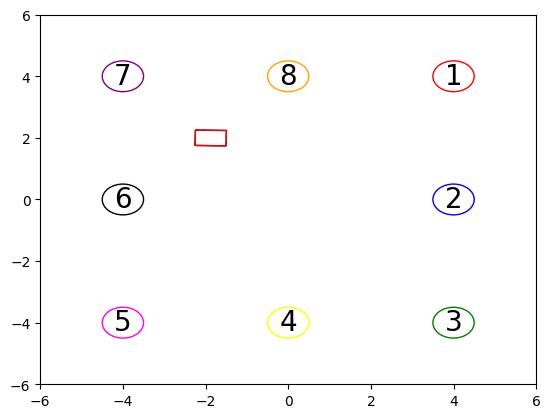

In [34]:
# Visualize final point (or trajectory)
fig = plt.figure()

ax = fig.add_subplot(111)

def rot(theta):
    return np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

for i in range(len(all_poses)-1, len(all_poses)):
# for i in range(0, len(all_poses), 40):
    # plt.cla()
    # Set the limits for the environment
    plt.xlim(-6, 6);
    plt.ylim(-6, 6);

    # Plot ground truth landmarks
    for k in range(len(landmarks)):
        rect = Circle(landmarks[k], 0.5, edgecolor = colors[k], fill=False)
        # add rectangle to plot
        ax.add_patch(rect)
        ax.annotate(str(k+1), xy=landmarks[k], fontsize=20, ha="center", va="center")

    # Plot actual pose
    p = np.copy(all_poses[i])
    # compute positions
    bpb = np.array([[-wheel_distance, -wheel_distance]]).T
    bpw = rot(p[0, 0]) @ bpb + p[1:, :]
    
    rect = Rectangle((bpw[0, 0], bpw[1, 0]), 3*wheel_distance, 2*wheel_distance, edgecolor = 'black', fill=False, angle=p[0, 0] * 180. / np.pi)
    # add rectangle to plot
    ax.add_patch(rect)

    # Plot odometry
    p = np.copy(odom_poses[i])
    # compute positions
    bpb = np.array([[-wheel_distance, -wheel_distance]]).T
    bpw = rot(p[0, 0]) @ bpb + p[1:, :]
    
    rect = Rectangle((bpw[0, 0], bpw[1, 0]), 3*wheel_distance, 2*wheel_distance, edgecolor = 'red', fill=False, angle=p[0, 0] * 180. / np.pi)
    # add rectangle to plot
    ax.add_patch(rect)

    # Plot EKF SLAM estimation
    p = np.copy(estimation[i][0][:3, :])
    # compute positions
    bpb = np.array([[-wheel_distance, -wheel_distance]]).T
    bpw = rot(p[0, 0]) @ bpb + p[1:, :]
    
    rect = Rectangle((bpw[0, 0], bpw[1, 0]), 3*wheel_distance, 2*wheel_distance, edgecolor = 'blue', fill=False, angle=p[0, 0] * 180. / np.pi)
    # add rectangle to plot
    ax.add_patch(rect)

    # Plot estimated landmarks
    f_est = estimation[i][0]
    sig_bar = estimation[i][1]
    for k in range(len(landmarks)):
        idx = 3 + k * 2
        x_pos = f_est[idx, 0]
        y_pos = f_est[idx+1, 0]
        if sig_bar[idx, idx] == UNSEEN: # ignore un-detected landmarks
            y_pos = -5.5
            x_pos = -5.25 + k * 1.5
        rect = Circle((x_pos, y_pos), 0.5, edgecolor = 'cyan', fill=False)
        # add rectangle to plot
        ax.add_patch(rect)
        ax.annotate(str(k+1), xy=(x_pos, y_pos), fontsize=20, ha="center", va="center")

plt.show();